In [ ]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip

--2021-06-14 03:26:15--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.120.194
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.120.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95592747 (91M) [application/octet-stream]
Saving to: ‘4drtyfjtfy-1.zip’

4drtyfjtfy-1.zip    100%[===================>]  91.16M  12.1MB/s    in 9.4s    

2021-06-14 03:26:26 (9.74 MB/s) - ‘4drtyfjtfy-1.zip’ saved [95592747/95592747]



In [ ]:
!unzip -qq 4drtyfjtfy-1.zip 
!unzip -qq dataset2.zip


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import random
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
path_label = []
labels = ['clo', 'rai', 'sun', 'shi']
for root, dirs, filenames in os.walk('dataset2'):
    for filename in filenames:
        tag = filename[:3]
        
        label = -1
        for index, label_name in enumerate(labels):
            if label_name in filename:
                label = index
        if label == -1:
            continue
        path = os.path.join(root, filename)
        image = cv2.imread(path)
        if image is None:
            continue
        try:
            first, last = os.path.splitext(filename)
            new_path = os.path.join(root, first + '.jpg')
            cv2.imwrite(new_path, image)
            path_label.append((new_path, label))
        except:
            print(filename)
            continue

In [ ]:
path_label[:10]

[('dataset2/cloudy110.jpg', 0),
 ('dataset2/sunrise154.jpg', 2),
 ('dataset2/sunrise235.jpg', 2),
 ('dataset2/shine44.jpg', 3),
 ('dataset2/cloudy4.jpg', 0),
 ('dataset2/sunrise283.jpg', 2),
 ('dataset2/rain22.jpg', 1),
 ('dataset2/cloudy36.jpg', 0),
 ('dataset2/cloudy298.jpg', 0),
 ('dataset2/sunrise282.jpg', 2)]

In [ ]:
def int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def floats_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [ ]:

writer_train = tf.io.TFRecordWriter('train.tfrecord')
writer_valid = tf.io.TFRecordWriter('valid.tfrecord')

print('total :', len(path_label))
count = 0
for path, label in path_label:
    print('\r', count, end='')
    count += 1
    file = open(path, 'rb')
    feat_dict = {}
    feat_dict['image'] = bytes_feature([file.read()])
    feat_dict['label'] = int64_feature([label])

    file.close()

    example = tf.train.Example(features=tf.train.Features(feature=feat_dict))
    if hash(path) % 10:
        writer_train.write(example.SerializeToString())
    else:
        writer_valid.write(example.SerializeToString())
print()
writer_train.close()
writer_valid.close()

total : 1123
 1122


In [ ]:
def read_tfrecord(example):
    tfrecord_format = (
        {
            'image':tf.io.FixedLenFeature([], tf.string),
            'label':tf.io.FixedLenFeature([], tf.int64)
        }
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = tf.io.decode_jpeg(example['image'])
    label = example['label']
    return image, label

In [ ]:
dataset_train = tf.data.TFRecordDataset('train.tfrecord')
dataset_valid = tf.data.TFRecordDataset('valid.tfrecord')
dataset_train = dataset_train.map(read_tfrecord)
dataset_valid = dataset_valid.map(read_tfrecord)

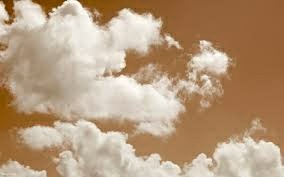

tf.Tensor(0, shape=(), dtype=int64)


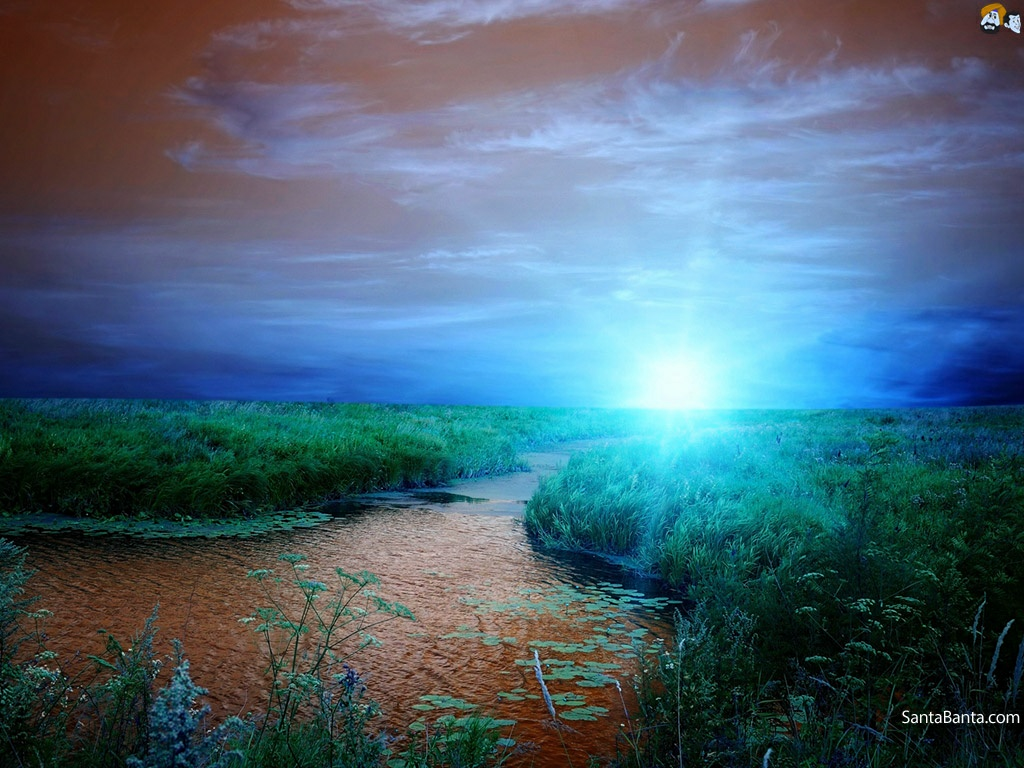

tf.Tensor(2, shape=(), dtype=int64)


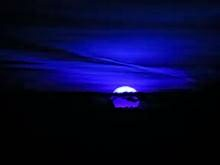

tf.Tensor(2, shape=(), dtype=int64)


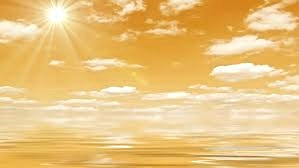

tf.Tensor(3, shape=(), dtype=int64)


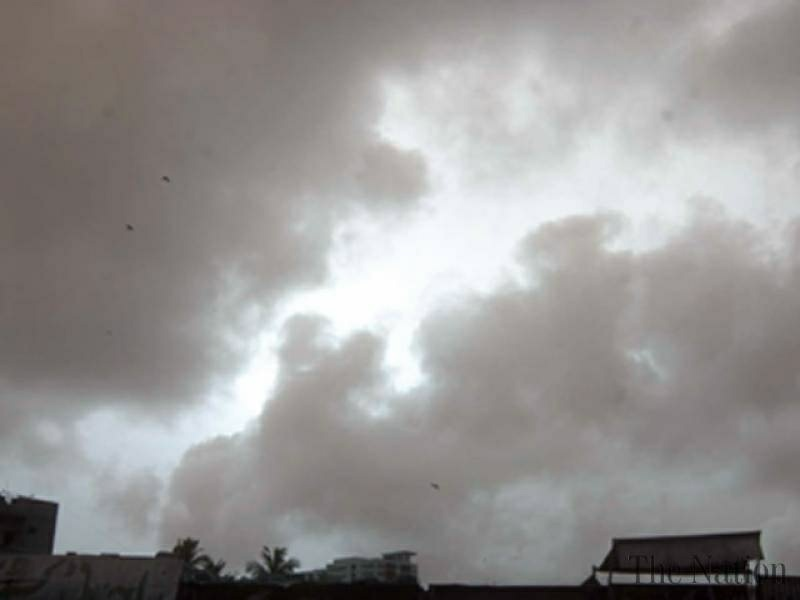

tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
for image, label in dataset_train.take(5):
    cv2_imshow(image.numpy())
    print(label)

In [ ]:
import random

def random_geometry(image, image_shape, target_size):
    width = image_shape[1]
    height = image_shape[0]
    #기본 위치
    x0 = 0
    y0 = 0
    x1 = width
    y1 = height

    #-- 크롭
    x0 = x0 + random.randint(0, width // 10)
    y0 = y0 + random.randint(0, height // 10)
    x1 = x1 - random.randint(0, width // 10)
    y1 = y1 - random.randint(0, height // 10)

    #--코너점
    corners = np.array(
        [
            [x0, y0, 1],
            [x1, y0, 1],
            [x1, y1, 1],
            [x0, y1, 1]
        ], dtype=np.float32)

    #-- 회전 + (스케일)
    aug_angle = random.uniform(-20, 20)
    #ori_width is center of nu_image
    rot_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), aug_angle, 1.0).astype(np.float32)
    corners = corners @ rot_matrix.T

    #-- 랜덤 추가
    corners += np.random.randn(4, 2) * (width / 30)

    #-- 호모그래피
    tw, ty = target_size
    target_corners = np.array(
        [
            [0, 0],
            [tw, 0],
            [tw, ty],
            [0, ty]
        ], dtype=np.float32)
    h = cv2.getPerspectiveTransform(corners, target_corners)
    dst = cv2.warpPerspective(image, h, target_size)
    return dst
    
def random_salt_and_papper(image):
    #salt and papper
    width = image.shape[1]
    height = image.shape[0]
    
    salts = [[0, 0, 0], [255, 255, 255], [0, 0, 255], [0, 255, 0], [255, 0, 0]]

    for salt in salts:
        if random.random() < 0.1:
            salt_count = int(width * height * 0.01 * random.random())
            y_coord = np.random.randint(0, height, [salt_count])
            x_coord = np.random.randint(0, width, [salt_count])
            image[y_coord, x_coord] = salt


def random_blur_or_shappen(image):
    blured = cv2.GaussianBlur(image, (5, 5), 7)
    weight = np.array(-0.7 + random.random() * 1.4, dtype=np.float32)
    image = image * (1 - weight) + blured * weight
    return image  


def random_flip(image):
    if random.random() > 0.5:
        image = cv2.flip(image, 1)
    return image

def random_lines(image):
    for ch in range(0, 2):
        if random.random() < 0.05:
            step = random.randint(3, 7)
            start = random.randint(0, step - 1)
            image[start::step, :, ch] = random.randint(0, 255)

    for ch in range(0, 2):
        if random.random() < 0.05:
            step = random.randint(3, 7)
            start = random.randint(0, step - 1)
            image[:, start::step, ch] = random.randint(0, 255)

def random_dim(image):
    for ch in range(0, 3):
        image[:, :, ch] += random.randint(-10, 10)
    return image

def random_ditter(image):
    if random.random() < 0.5:
        image += np.random.normal(0, random.randint(1, 20), image.shape)


def random_multi_tone(image):
    if random.random() < 0.1:
        sep = random.randint(image.shape[1] // 4, image.shape[1] * 3 // 4)
        offset = (np.random.random([3]) - 0.5) * 30
        image[:, :sep, :] += offset
        offset = (np.random.random([3]) - 0.5) * 30
        image[:, sep:, :] += offset
    if random.random() < 0.1:
        sep = random.randint(image.shape[0] // 4, image.shape[0] * 3 // 4)
        offset = (np.random.random([3]) - 0.5) * 30
        image[:sep, :, :] += offset
        offset = (np.random.random([3]) - 0.5) * 30
        image[sep:, :, :] += offset

def random_shadow(image):
    width = image.shape[1]
    height = image.shape[0]

    ver_shadow = (np.arange(height) - (height / 2)) / (height / random.randint(1, 30))
    hor_shadow = (np.arange(width) - (width / 2)) / (width / random.randint(1, 30))

    ver_shadow = np.linspace(0, 1, height).reshape([-1, 1, 1]) - 0.5
    hor_shadow = np.linspace(0, 1, width).reshape([1, -1, 1]) - 0.5
    
    ver_shadow *= np.random.randn() * 40
    hor_shadow *= np.random.randn() * 40

    image += ver_shadow.astype(np.float32)
    image += hor_shadow.astype(np.float32)



In [ ]:
def aug_all_numpy(image, shape):
    image = random_geometry(image, shape, target_size=(224, 224))
    # image = cv2.resize(image, (224, 224))
    image = random_flip(image)
    image = image.astype(np.float32)

    # image = random_blur_or_shappen(image)
    # random_dim(image)
    random_ditter(image)
    # random_multi_tone(image)
    # random_shadow(image)

    image = np.clip(image, 0, 255)

    # random_lines(image)
    random_salt_and_papper(image)
    # image = image.astype(np.uint8)
    return image


def aug_train(image, label):
    image = tf.numpy_function(aug_all_numpy, [image, tf.shape(image)], tf.float32)
    image = keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

def aug_valid(image, label):
    image = tf.image.resize(image, (224, 224))
    image = keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

In [ ]:
dt = dataset_train.map(aug_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dv = dataset_valid.map(aug_valid, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dt = dt.repeat().batch(32).prefetch(1)
dv = dv.batch(32).prefetch(1)

In [ ]:
pre_model = keras.applications.mobilenet_v2.MobileNetV2(include_top=False)
output = keras.layers.GlobalAveragePooling2D()(pre_model.output)
output = keras.layers.Dense(4, activation='softmax')(output)
model = keras.models.Model(inputs=[pre_model.input], outputs=output)

for layer in pre_model.layers:
    layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
for image, label in dt.take(2):
    print(label)

tf.Tensor([0 2 2 3 0 2 1 0 2 2 0 3 2 2 3 1 0 2 3 2 0 0 2 2 3 0 2 2 1 2 0 1], shape=(32,), dtype=int64)
tf.Tensor([1 2 0 3 1 2 1 0 1 2 2 3 0 0 3 2 2 0 1 3 1 2 0 1 2 1 3 0 2 3 1 1], shape=(32,), dtype=int64)


In [ ]:
output.shape

TensorShape([None, 4])

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#aug 없음
callbacks = [tf.keras.callbacks.TensorBoard('log_dir', update_freq='batch')]
model.fit(dt, steps_per_epoch=700, epochs=2, validation_data=dv, callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/2
700/700 [==============================] - 721s 1s/step - loss: 0.2201 - accuracy: 0.9227 - val_loss: 0.1437 - val_accuracy: 0.9478
Epoch 2/2
700/700 [==============================] - 711s 1s/step - loss: 0.1019 - accuracy: 0.9654 - val_loss: 0.1331 - val_accuracy: 0.9478
